# Régression linéaire et Ridge sur Spark

Dans ce devoir, nous allons nous concentrer sur la régression linéaire sur Spark. Dans un premier temps, nous nous consacrerons à une régression linéaire simple, puis dans un second temps, nous ajouterons une pénalisation de type L2 afin de voir si celle-ci permet d'obtenir de meilleurs résultats prédictifs. Ainsi, ce travail consistera essentiellement à mettre en place une descente de gradient distribuée sur Spark.

Afin de comparer les performances à la fois prédictives et en temps de calculs, des algorithmes implémentés, nous utiliserons également la librairie MLlib qui recense l'intégralité de ces algorithmes.

## Partie 1 : Préliminaires

In [21]:
# Importation des librairies

import os.path
import pandas as pd
from pyspark.mllib.regression import LabeledPoint
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
from pyspark.mllib.linalg import DenseVector
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
from pyspark.mllib.regression import LinearRegressionWithSGD

### 1.1 : Création de la base

Nous allons créer une matrice avec 21 variables $(Y, X_1...X_{20})$ et 1000 observations. Y, la variable à prédire, est une combinaise linéaire de $X_1,...,X_{10}$ et est indépendant de $X_{11},...X_{50}$.
On ajoute un bruit, epsilon suivant une loi normale $\mathcal{N}(0, 50)$. Finalement, nous pouvons résumer nos simulations par la relation suivante : 
$$ Y_i = \sum_{j=1}^{10} \beta_j x_i^j + \epsilon_i  $$
où $\beta_j = j$.

In [2]:
np.random.seed(1)
nb_obs=1000
x = np.random.rand(nb_obs, 20)*100
beta = list(range(1,11)) + [0] * 10
eps = np.random.normal(0,50,size=nb_obs)
y = x.dot(beta) + eps
mat = np.c_[y,x]
mat[:2,]

array([[  1.74761413e+03,   4.17022005e+01,   7.20324493e+01,
          1.14374817e-02,   3.02332573e+01,   1.46755891e+01,
          9.23385948e+00,   1.86260211e+01,   3.45560727e+01,
          3.96767474e+01,   5.38816734e+01,   4.19194514e+01,
          6.85219500e+01,   2.04452250e+01,   8.78117436e+01,
          2.73875932e+00,   6.70467510e+01,   4.17304802e+01,
          5.58689828e+01,   1.40386939e+01,   1.98101489e+01],
       [  2.81023549e+03,   8.00744569e+01,   9.68261576e+01,
          3.13424178e+01,   6.92322616e+01,   8.76389152e+01,
          8.94606664e+01,   8.50442114e+00,   3.90547832e+00,
          1.69830420e+01,   8.78142503e+01,   9.83468338e+00,
          4.21107625e+01,   9.57889530e+01,   5.33165285e+01,
          6.91877114e+01,   3.15515631e+01,   6.86500928e+01,
          8.34625672e+01,   1.82882773e+00,   7.50144315e+01]])

Nous allons transformer notre array en un RDD afin de pouvoir paralléliser les calculs. Nous testons également si la première observation du RDD est bien égale à la première observation de l'array.

In [3]:
data=sc.parallelize(mat)            # On crée un RDD à partir de la matrice mat

print(np.all(data.first()==mat[0])) 
nb_obs = data.count()
print(nb_obs)                       # Nombre d'observations

True
1000


### 1.2 : Utilisation des LabeledPoint

La fonction suivante prend en entrée une ligne du RDD dans laquelle le premier élément est le label de l'observation et retourne un LabeledPoint, c'est à dire un élement contenant le label et l'ensemble des features associés.

In [4]:
def feat_label_fun(line):
    return LabeledPoint(line[0], line[1:])

Regardons avec un exemple simple comment fonctionne la fonction. Prenons la première ligne de notre RDD.

In [5]:
obs = data.take(1)                               # Prend la première ligne du rdd 
obs_labelisee = list(map(feat_label_fun, obs))   # on applique la fonction feat_label_fun au rdd
features = obs_labelisee[0].features             # on recupère les features
label = obs_labelisee[0].label                   # on recupère les labels
print("features: {0}".format(features))
print("label: {0}".format(label))

features: [41.7022004703,72.0324493442,0.0114374817345,30.2332572632,14.6755890817,9.23385947688,18.6260211378,34.5560727043,39.6767474231,53.8816734003,41.9194514403,68.5219500397,20.4452249732,87.8117436391,2.73875931979,67.0467510178,41.7304802367,55.8689828446,14.0386938595,19.8101489085]
label: 1747.61412667


Appliquons maintenant cette fonction à l'ensemble de la base.

In [6]:
data_labelisee = data.map(feat_label_fun)
labels = data_labelisee.map(lambda x: x.label)
features = data_labelisee.map(lambda x: x.features)

### 1.3 : Séparation de la base en train et test

On sépare les données en train et test (70%, 30%). Notons que nous allons utiliser la fonction cache puisque nous allons accéder à ces RDD plusieurs fois pendant l'apprentissage ce qui permet un gain de temps.

In [7]:
weights = [.7, 0.3]
seed = 1
train, test = data_labelisee.randomSplit(weights, seed)
train.cache() 
test.cache()
n_train = train.count()
n_test = test.count()

print (n_train, n_test)
np.all(n_train + n_test==nb_obs)         # On vérifie que la taille des deux jeux de données est égale à celle de
                                         # la base complète

(690, 310)


True

Afin de calculer les performances prédictives de nos algorithmes, nous allons utiliser la métrique RMSE, qui est pertinente dans le cas de données continues, comme c'est le cas ici.

In [8]:
def squared_error(label, prediction):
    """ Permet de calculer l'erreur de prédiction pour une observation"""
    return (label - prediction)**2

def calcRMSE(labels_and_preds):
    """Calcule le "Root mean squared error" d'un RDD"""
    return np.sqrt(labels_and_preds.map(lambda x: squared_error(x[0], x[1])).mean())

### Partie 2 : Régression Linéaire

Nous allons désormais effectuer une régression linéaire. Nous allons entrainer notre modèle en utilisant une descente de gradient : 

$$  \mathbf{\beta}_{i+1} = \mathbf{\beta}_i - \alpha_i \sum_j (\mathbf{\beta}_i'\mathbf{x}_j  - y_j) \mathbf{x}_j \,.$$ où i  est le nombre d'itération et $\alpha$ est le pas. 

- On implemente tout d'abord la fonction calculant de façon matricielle : $ \scriptsize (\mathbf{w}^\top \mathbf{x}_j - y_j) \mathbf{x}_j \, ,$ 

In [9]:
def gradient_summand(beta, lp):
    return (beta.dot(lp.features) - lp.label) * lp.features

- Désormais on implemente la fonction `get_labeled_predictions` qui prend les coefficients et les observations (LabeledPoint) en input et retourne un tuple (label, prediction).

In [10]:
def get_labeled_prediction(beta, observation):
    return (observation.label, beta.T.dot(observation.features))

On implemente désormais la descente de gradient qui utilise les deux fonctions précédentes. Cette fonction prend en entrée une base d'apprentissage, un nombre d'itérations et alpha, le pas et retourne l'erreur commise sur cette base ainsi que les beta finaux. 
A chaque itération i, celle-ci calcule l'erreur RMSE sur la base. Notons qu'à la première itération, les $\beta$ sont fixés à 0, ainsi le label n'est pas relié au features et le modèle prédit 0. L'erreur commise est donc potentiellement très grande.

### 2.1 : Implémentation de la descente de gradient et résultats

In [11]:
def linreg_gradient_descent(train_data, num_iters, alpha):
    
    n = train_data.count()                           # le nombre d'observation de la base train_data
    d = len(train_data.take(1)[0].features)          # le nombre de features 
    beta = np.zeros(d)                                  # poids initiaux fixés à 0
    error_train = np.zeros(num_iters)
    
    for i in range(num_iters):
        labels_and_preds_train = train_data.map(lambda x: get_labeled_prediction(beta, x))
        error_train[i] = calcRMSE(labels_and_preds_train)

        gradient = train_data.map(lambda x: gradient_summand(beta, x)).sum()       # calcul du gradient
        alpha_i = alpha / (n * np.sqrt(i+1))                                    # mise à jour du pas
        beta = beta - alpha_i * gradient                                              # mise à jour des poids
        
    return beta, error_train

Regardons quels sont les résultats sur notre base de données, à la fois en termes de prédictions et de temps de calculs.

In [14]:
num_iters = 500
alpha = 0.0001
now = time.time()
weightsLR0, error_trainLR0 = linreg_gradient_descent(train, num_iters, alpha)
print("Temps écoulé : " + str(time.time()-now))

labels_and_preds = test.map(lambda x: get_labeled_prediction(weightsLR0, x))
rmse_valLR0 = calcRMSE(labels_and_preds)

print('RMSE sur test : ' + str(rmse_valLR0))
print("Beta chapeau")
print(weightsLR0)

Temps écoulé : 51.6085760593
RMSE sur test : 55.0348244564
Beta chapeau
[ 1.10688161  1.96229727  2.93135514  3.92280552  4.85654687  5.82884078
  6.90858489  7.90960549  8.69810285  9.89847253  0.38049444  0.1707231
  0.0957132   0.02251207  0.07108871  0.07586515 -0.10619262  0.09280393
  0.05012069  0.10334102]


L'algorithme a mis plus de 50 secondes à tourner mais les paramètres estimés sont assez proches des $\beta$ utilisés pour la simulation.

Nous avons créer la fonction suivante afin d'effectuer des graphs de manière plus rapide.

In [15]:
def prepare_plot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

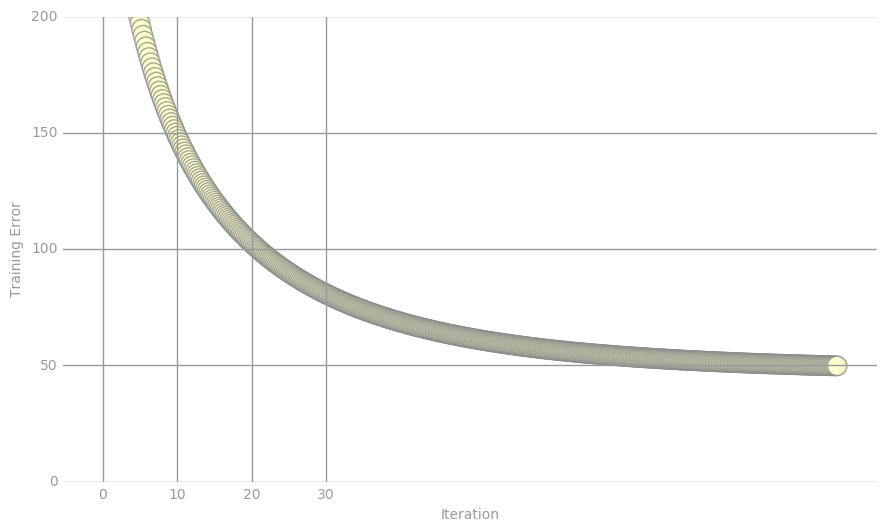

In [20]:
norm = Normalize()
clrs = cmap(np.asarray(norm(error_trainLR0[6:])))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 200, 50), np.arange(0, 210, 50))
ax.set_ylim(0, 200)
plt.scatter(range(0, num_iters-6), error_trainLR0[6:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xticklabels(map(str, range(0, 200, 10)))
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
pass

Le graph précédent montre bien que l'algorithme a convergé puisque plus le nombre d'itérations augment, plus l'erreur sur le train diminue.

### 2.2 : Implémentation avec Mllib

In [25]:
num_iters=200
alpha = 0.0001         # pas
mini_batch_frac = 1.0  # prend toute la base pour la descente de gradient (pas d'aléa)
reg = 0  # lambda
reg_type = 'none'  # pas de regularisation
use_intercept = False  # pas d'intercept

In [26]:
now = time.time()
modele_lineaire = LinearRegressionWithSGD.train(train, iterations=num_iters, step=alpha,
                                           miniBatchFraction=mini_batch_frac, regParam=reg,
                                           regType=reg_type, intercept=use_intercept)
print(time.time()-now)

# weightsLR1 stores the model weights; interceptLR1 stores the model intercept
beta_lineaire = modele_lineaire.weights
print beta_lineaire


1.7341811657
[1.63088515864,1.82515539982,2.72757229143,3.71195556685,4.53479344227,5.17482173889,6.40271052257,7.33239127769,7.7638460305,9.05821574239,0.953370959068,0.57466628143,0.686943106017,0.386603763521,0.310236525502,0.505649592616,0.121665161538,0.391431674461,0.469909904501,0.430547012322]


In [27]:
labels_and_preds = test.map(lambda x: (x.label, modele_lineaire.predict(x.features)))
rmse_test_lineaire = calcRMSE(labels_and_preds)

print("RMSE")
print(rmse_test_lineaire)

RMSE
96.0518972755


A nouveau, les résultats sont plutôt satisafaisants.

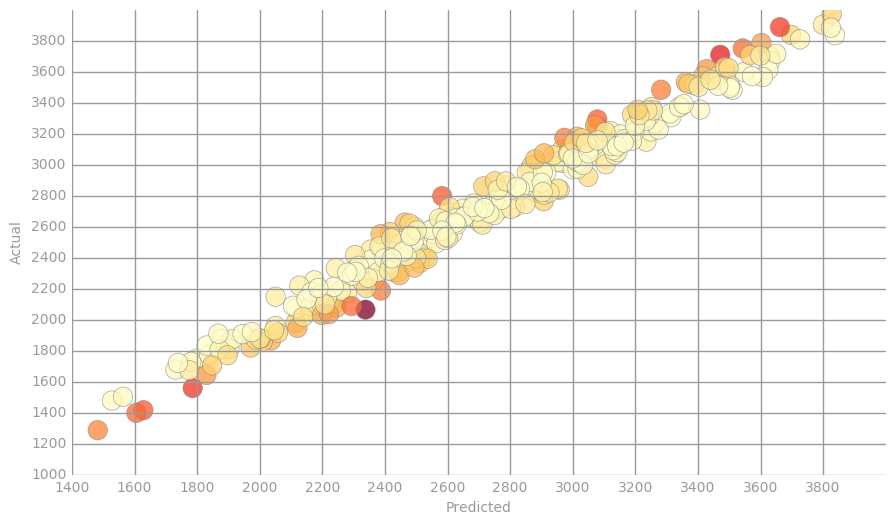

In [28]:
predictions = np.asarray(test
                         .map(lambda lp: modele_lineaire.predict(lp.features))
                         .collect())
actual = np.asarray(test
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(test
                   .map(lambda lp: (lp.label, modele_lineaire.predict(lp.features)))
                   .map(lambda (l, p): squared_error(l, p))
                   .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 4000, 200), np.arange(0, 4000, 200))
ax.set_xlim(1400, 4000), ax.set_ylim(1000, 4000)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
pass

### Partie 3 : Régression Ridge

Dans cette partie, nous ajoutons une pénalisation de type L2 à la descente de gradient. Ainsi, l'estimateur de $\beta$ par ridge par la régularisation L2 est solution de :
$$ \hat{\beta}^{ridge} = \underset{\beta}{\text{arg min}}  \sum_{i=1}^n (y_i - x_i'\beta)^2 + \lambda \sum_{j=1}^p \beta_j^2  $$
où $\lambda$ désigne le niveau de pénalité : si $\lambda$ tend vers 0, on retrouve l'estimateur des moindres carré. La relation à implémenter pour la descente de gradient associée à ce problème de minimisation est donc la suivante :
$$ \mathbf{\beta}_{i+1} = \mathbf{\beta}_i - \alpha_i \sum_j (\beta_i' x_j  - y_j) \mathbf{x}_j + \lambda \beta$$ 
Nous allons implémenter la descente de gradient associée à cette nouvelle fonction à minimiser. Elle prend en input à nouveau, la base d'apprentissage, le nombre d'itérations à accomplir, le pas $\alpha$ et le paramètre $\lambda$ et retourne les $\beta$ finaux ainsi que l'erreur commise à chaque itération.

### 3.1 : Implémentation de la descente de gradient et résultats

In [15]:
def descente_gradient_ridge(train_data, nb_iter, alpha, lambda_param):
    
    n = train_data.count()
    d = len(train_data.take(1)[0].features)
    beta = np.zeros(d)
    alpha = alpha
    error_train = np.zeros(nb_iter)
    
    for i in range(nb_iter):
        labels_and_preds_train = train_data.map(lambda x: get_labeled_prediction(beta, x))
        error_train[i] = calcRMSE(labels_and_preds_train)
        gradient = train_data.map(lambda x: gradient_summand(beta, x)).sum()  # calcul du grandient
        gradient = gradient + lambda_param * beta                             # on ajoute la penalisation au gradient
        alpha_i = alpha / (n * np.sqrt(i+1))                                  # mise à jour du pas
        beta = beta - alpha_i * gradient                                      # mise à jour des beta
    
    return beta, error_train

Regardons les résultats sur notre base de données ainsi que le temps de calcul de la fonction. Après plusieurs essais, nous avons choisi un pas $\alpha$ très faible associé à un nombre d'itérations assez élevé ainsi qu'un $\lambda$ de 0.1.

In [ ]:
nb_iter = 500
alpha = 0.0001
Lambda = 0.1

now = time.time()
beta_lineaire, erreur_lineaire = descente_gradient_ridge(train, nb_iter, alpha, Lambda)
print("Temps écoule : " + str(time.time()-now))

labels_and_preds = test.map(lambda x: get_labeled_prediction(beta_lineaire, x))
rmse_L2 = calcRMSE(labels_and_preds)

print("Beta chapeau")
print(beta_lineaire)
print('RMSE sur test : ' + str(rmse_L2))


Il semble que la fonction ait mis près de 50 secondes à fournir un résultat et donne une erreur RMSE sur la base test de près de 19. De plus, si nous regardons les $\hat{\beta}$ obtenus, ils sont très proches des vrais paramètres simulés. La descente de gradient semble donc assez satisfaisante. Néanmoins, il est clair que ces résultats ne sont pas optimaux et la libraire MLlib pourra en être témoin.

### 3.2 : Implémentation avec la librairie MLlib

Nous allons effectuer une régression linéaire avec pénalisation L2 grâce à la fonction $\verb?LinearRegressionWithSGD?$ de la librairie MLlib. Celle-ci permet d'effectuer une descente de gradient stochastique. Dans cet algorithme, l'aléa provient du paramètre $\verb?miniBatchFraction?$ qui permet de prendre, à chaque itération, une fraction aléatoire de l'échantillon pour calculer le gradient. Afin de pouvoir faire une comparaison pertinente, nous avons fixé ce paramètre à 1. Ainsi, nous avons affaire ici, à une descente de gradient en $\textit{batch}$.

Pour ce qui est des autres paramètres, nous avons choisi le même pas $\alpha$, le même nombre d'itération et le même niveau de pénalisation $\lambda$ que pour la descente de gradient effectuée précédemment à nouveau dans un but d'avoir une comparaison la plus pertinente possible.

Enfin, nous avons gardé l'estimation de l'intercept afin de voir si l'algorithme le fixe bien à une valeur proche de 0.

In [92]:
nb_iter=500              # nombre d'itérations
alpha = 0.0001           # pas
miniBatchFraction = 1.0  # aucun aléa
Lambda = 0.1             # lambda
regType = 'l2'           # pénalisation de type L2
intercept = False         # intercept

In [93]:
now = time.time()
modele_L2 = LinearRegressionWithSGD.train(train, iterations=nb_iter, step=alpha,
                                           miniBatchFraction=miniBatchFraction, regParam=Lambda,
                                           regType=regType, intercept=intercept)
print("Temps écoulé : " + str(time.time()-now))

beta_L2_mllib = modele_L2.weights
print("Beta chapeau")
print(beta_L2_mllib)

#intercept = modele_L2.intercept
#print("intercept : " + str(intercept))

labels_and_preds_mllib = test.map(lambda x: (x.label, modele_L2.predict(x.features)))
rmse_test_L2_mllib = calcRMSE(labels_and_preds_mllib)
print("RMSE sur test : " + str(rmse_test_L2_mllib))


1.08483719826
[1.00240463749,2.00647035393,2.99361026269,4.00324193214,5.00238016096,6.00410522273,6.98651801215,8.00040102116,9.00131664892,9.99217005346]


Il est clair que cette fonction est bien plus efficace d'un point de vu rapidité avec un temps de calcul divisé par plus de 10 entre la version de MLlib et celle implémentée par nos soins. De plus, les paramètres estimés semblent être assez proches des paramètres utilisée. En revanche, il semble que le calcul de la valeur de la RMSE ne soit pas comparable avec celle obtenue grâce à l'implémentation de la descente de gradient.

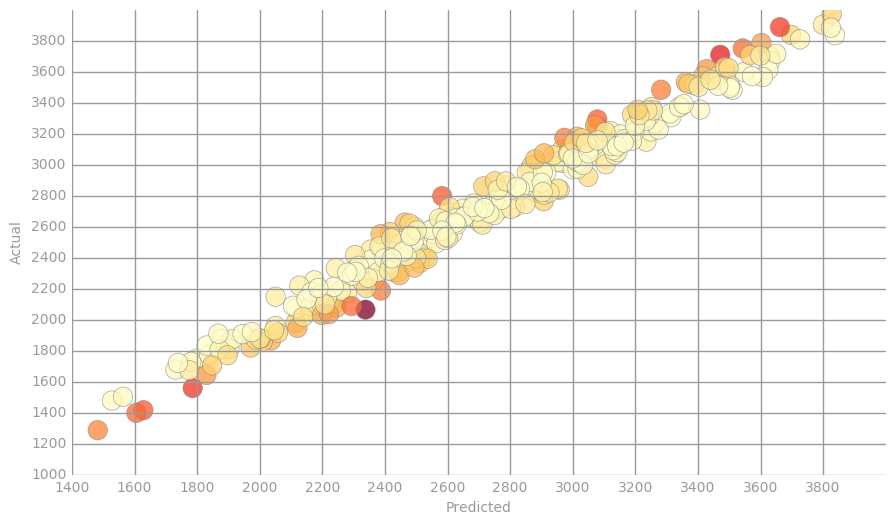

In [30]:
predictions = np.asarray(test.map(lambda lp: modele_lineaire.predict(lp.features)).collect())
labels = np.asarray(test.map(lambda lp: lp.label).collect())
error = np.asarray(test
                   .map(lambda lp: (lp.label, modele_lineaire.predict(lp.features)))
                   .map(lambda (l, p): squared_error(l, p))
                   .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 4000, 200), np.arange(0, 4000, 200))
ax.set_xlim(1400, 4000), ax.set_ylim(1000, 4000)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
pass

Nous avons réussi à correctement implémenter les descentes de gradient des modèles linéaires et Ridge. En effet, les résultats des coefficients obtenus grâce à l'algorithme de descente de gradient sont très proches de ceux du vrai modèle réalisé par simulation au début du notebook, aussi bien pour notre algorithme que pour Mllib.
Grâce à la librairie pyspark, nous sommes en mesure de paralléliser notre code. Cependant pour comprendre véritablement l'intérêt au niveau du temps de calcul, il faudrait pouvoir avoir accès à des clusters et travailler sur une base de données bien plus grande.